# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# BiLSTM-CRF Implementation

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class BiLSTM_CRF(nn.Module):
    def __init__(self, input_size, hidden_size, num_tags):
        super(BiLSTM_CRF, self).__init__()
        self.hidden_size = hidden_size
        self.num_tags = num_tags
        # BiLSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(2*hidden_size, num_tags)
        # CRF layer
        self.crf = CRF(num_tags)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def neg_log_likelihood(self, x, tags):
        emissions = self(x)
        return -self.crf(emissions, tags)

    def forward_crf(self, x):
        emissions = self(x)
        out = self.crf.decode(emissions)
        out = torch.tensor(out)
        out = torch.nn.functional.one_hot(out, num_classes=self.num_tags)
        out = out.permute(1, 0, 2) # (len, 1, num_tags) to (1, len, num_tags)
        out = out.to(device=x.device)
        return out

# Example usage:
input_size = 300  # Example input size
hidden_size = 128  # Example hidden size
num_tags = 27  # Example number of tags
criteria = nn.CrossEntropyLoss()

# Example forward pass with CRF
model = BiLSTM_CRF(input_size, hidden_size, num_tags)
inputs = torch.randn(1, 19, input_size)  # Example input tensor
tags = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])  # Example tag tensor

neg_log_likelihood = model.neg_log_likelihood(inputs, tags)
decoded_tags = model.forward_crf(inputs)
print(inputs.shape, tags.shape)
print(decoded_tags.shape)
test_out = model(inputs)
print(test_out.shape)
loss = criteria(decoded_tags.float().view(-1, 27), tags.squeeze(0))
print(neg_log_likelihood)

torch.Size([1, 19, 300]) torch.Size([1, 19])
torch.Size([1, 19, 27])
torch.Size([1, 19, 27])
tensor(62.9365, grad_fn=<NegBackward0>)


# Training and Validation Code

In [4]:
def clean_word(word):
    import string
    clean_word = word.translate(str.maketrans('', '', string.punctuation))
    clean_word = clean_word.strip()
    if not clean_word:
        return ' ' * len(word)
    else:
        return clean_word
    
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            # Compute loss
            # targets = targets.squeeze(0)
            # loss = criterion(outputs.float().view(-1, output_size), targets)
            loss = model.neg_log_likelihood(embedded_text, targets)
            targets = targets.squeeze(0)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model.forward_crf(embedded_text)
                # Compute loss
                # targets = targets.squeeze(0)
                # loss = criterion(outputs.float().view(-1, output_size), targets)
                loss = model.neg_log_likelihood(embedded_text, targets)
                targets = targets.squeeze(0)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            # Compute loss
            # targets = targets.squeeze(0)
            # loss = criterion(outputs.float().view(-1, output_size), targets)
            loss = model.neg_log_likelihood(embedded_text, targets)
            targets = targets.squeeze(0)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label] for label in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.squeeze(0).tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            label = label[2:] if label != 'O' else label
            labelwise_predictions[label] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            actual_bio_label = list(label_mapping.keys())[list(label_mapping.values()).index(test_actual[i])]
            actual_label = actual_bio_label[2:] if actual_bio_label != 'O' else actual_bio_label
            predicted_bio_label = list(label_mapping.keys())[list(label_mapping.values()).index(test_predicted[i])]
            predicted_label = predicted_bio_label[2:] if predicted_bio_label != 'O' else predicted_bio_label
            labelwise_predictions[actual_label]["actual"].append(1)
            labelwise_predictions[actual_label]["predicted"].append(1 if actual_label == predicted_label else 0)
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xticks(rotation=90)
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
            plt.bar(labelwise_accuracy.keys(), labelwise_accuracy.values())
            plt.xticks(rotation=90)
            plt.xlabel('Label')
            plt.ylabel('Accuracy')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
bilstmcrf_word2vec_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_word2vec_model.parameters(), lr=0.001)

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=3)

Epoch 1/3
Training: Loss: 9.2096, Accuracy: 0.9231, F1: 0.4980
Validation: Loss: 6.3337, Accuracy: 0.9428, F1: 0.6392
Epoch 2/3
Training: Loss: 5.1464, Accuracy: 0.9523, F1: 0.6896
Validation: Loss: 5.4691, Accuracy: 0.9500, F1: 0.6896
Epoch 3/3
Training: Loss: 3.7909, Accuracy: 0.9648, F1: 0.7801
Validation: Loss: 5.4433, Accuracy: 0.9512, F1: 0.7118


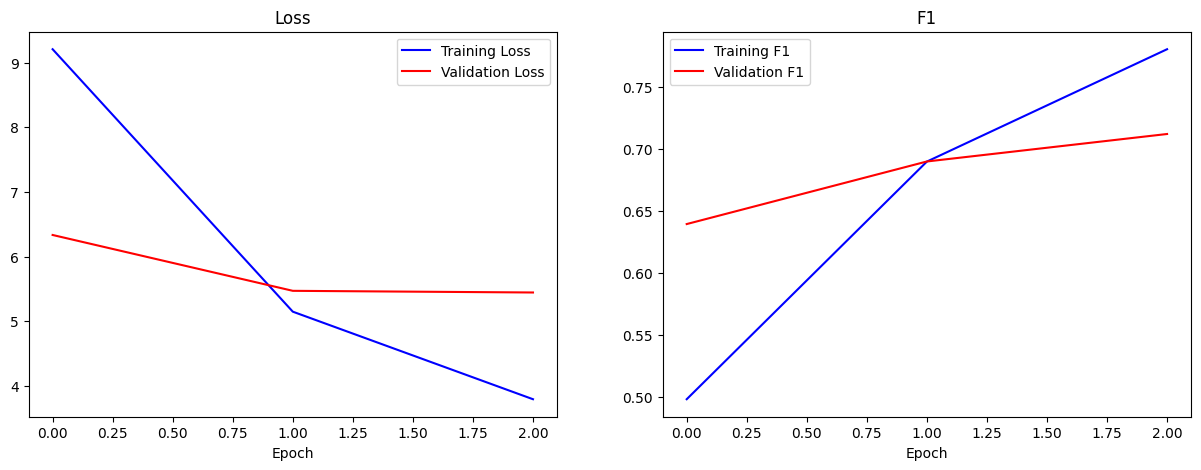

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
bilstmcrf_word2vec_model = bilstmcrf_word2vec_model.to('cpu')
torch.save(bilstmcrf_word2vec_model, "t1_model4_word2vec.pt")

Labelwise F1 Scores:
{'O': 0.4965993877064657, 'CASE_NUMBER': 0.41656210790464243, 'ORG': 0.3020833333333333, 'OTHER_PERSON': 0.4097744360902255, 'STATUTE': 0.48246364414029086, 'PROVISION': 0.4633204633204633, 'COURT': 0.46835443037974683, 'WITNESS': 0.42268041237113396, 'PRECEDENT': 0.4744993324432577, 'DATE': 0.46798029556650245, 'PETITIONER': 0.3548387096774194, 'GPE': 0.3512747875354108, 'RESPONDENT': 0.22222222222222224, 'JUDGE': 0.4444444444444445}
Labelwise Accuracy Scores:
{'O': 0.986489439184268, 'CASE_NUMBER': 0.7139784946236559, 'ORG': 0.43283582089552236, 'OTHER_PERSON': 0.6942675159235668, 'STATUTE': 0.9322314049586777, 'PROVISION': 0.8633093525179856, 'COURT': 0.8809523809523809, 'WITNESS': 0.7321428571428571, 'PRECEDENT': 0.9029471544715447, 'DATE': 0.8796296296296297, 'PETITIONER': 0.55, 'GPE': 0.5414847161572053, 'RESPONDENT': 0.2857142857142857, 'JUDGE': 0.8}


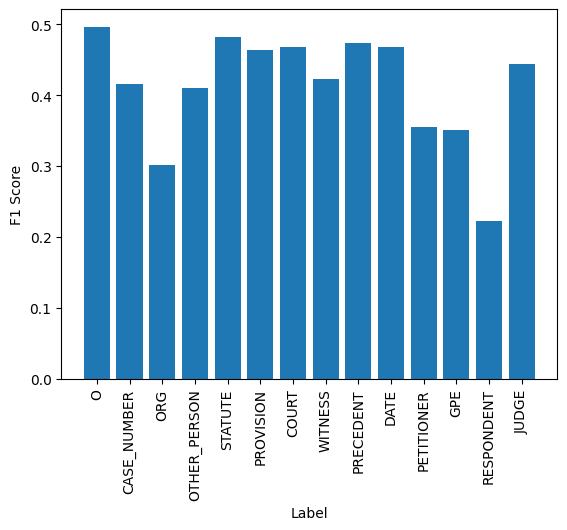

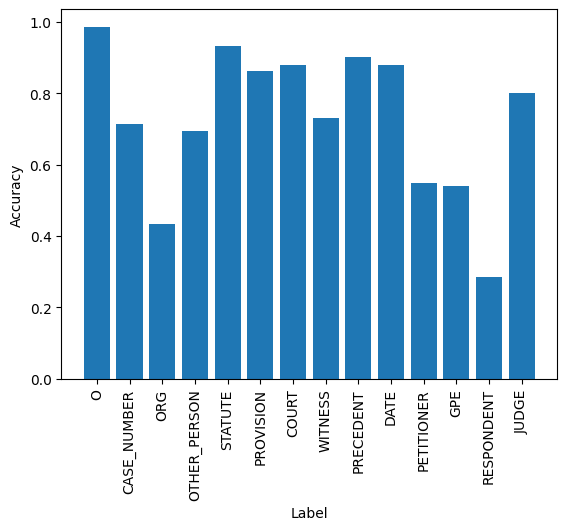

Bi-LSTM CRF with Word2Vec ==> Accuracy: 0.9521, F1: 0.6967


In [13]:
test_accuracy, test_f1 = test("t1_model4_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load("t1_model4_word2vec.pt")

label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
label_mapping_reverse = {v: k for k, v in label_mapping.items()}
label_mapping_without_bio = {'O': 0, 'CASE_NUMBER': 1, 'ORG': 2, 'OTHER_PERSON': 3, 'STATUTE': 4, 'PROVISION': 5, 'COURT': 6, 'WITNESS': 7, 'PRECEDENT': 8, 'DATE': 9, 'PETITIONER': 10, 'GPE': 11, 'RESPONDENT': 12, 'JUDGE': 13}

f1_labelwise = {}
model = model.to(device)
model.eval()

for label in label_mapping_without_bio:
    print(label)
    actual = []
    predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, word2vec, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([[label_mapping[label_] for label_ in labels]], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model.forward_crf(embedded_text)
            for actual_label, predicted_label in zip(targets.squeeze(0).tolist(), outputs.squeeze(0).argmax(dim=1).tolist()):
                actual_label_name = label_mapping_reverse[actual_label]
                actual_label_name = actual_label_name[2:] if actual_label_name != 'O' else actual_label_name
                predicted_label_name = label_mapping_reverse[predicted_label]
                predicted_label_name = predicted_label_name[2:] if predicted_label_name != 'O' else predicted_label_name
                if actual_label_name == label:
                    actual.append(1)
                    predicted.append(1 if actual_label_name == predicted_label_name else 0)
        f1_labelwise[label] = {"f1": f1_score(actual, predicted, average="macro"), "accuracy": accuracy_score(actual, predicted)}

O


CASE_NUMBER
ORG
OTHER_PERSON
STATUTE
PROVISION
COURT
WITNESS
PRECEDENT
DATE
PETITIONER
GPE
RESPONDENT
JUDGE


In [15]:
f1_labelwise

{'O': {'f1': 0.49561927153169366, 'accuracy': 0.9826292789512018},
 'CASE_NUMBER': {'f1': 0.3673469387755102, 'accuracy': 0.5806451612903226},
 'ORG': {'f1': 0.19829059829059828, 'accuracy': 0.24733475479744135},
 'OTHER_PERSON': {'f1': 0.3328611898016997, 'accuracy': 0.4989384288747346},
 'STATUTE': {'f1': 0.3300110741971207, 'accuracy': 0.4925619834710744},
 'PROVISION': {'f1': 0.4488501189532117, 'accuracy': 0.814388489208633},
 'COURT': {'f1': 0.4220183486238532, 'accuracy': 0.7301587301587301},
 'WITNESS': {'f1': 0.4042553191489362, 'accuracy': 0.6785714285714286},
 'PRECEDENT': {'f1': 0.432198499711483, 'accuracy': 0.7611788617886179},
 'DATE': {'f1': 0.4508474576271186, 'accuracy': 0.8209876543209876},
 'PETITIONER': {'f1': 0.25925925925925924, 'accuracy': 0.35},
 'GPE': {'f1': 0.24422442244224418, 'accuracy': 0.3231441048034934},
 'RESPONDENT': {'f1': 0.22222222222222224, 'accuracy': 0.2857142857142857},
 'JUDGE': {'f1': 0.16666666666666669, 'accuracy': 0.2}}

# For GloVe Embeddings

In [16]:
input_size, hidden_size, output_size = 300, 128, 27
bilstmcrf_glove_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_glove_model.parameters(), lr=0.001)

In [17]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            bilstmcrf_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 12.8658, Accuracy: 0.8927, F1: 0.2971
Validation: Loss: 10.3489, Accuracy: 0.9076, F1: 0.3749
Epoch 2/10
Training: Loss: 9.2939, Accuracy: 0.9153, F1: 0.4364
Validation: Loss: 9.6929, Accuracy: 0.9130, F1: 0.4487
Epoch 3/10
Training: Loss: 8.1757, Accuracy: 0.9234, F1: 0.4982
Validation: Loss: 9.8621, Accuracy: 0.9118, F1: 0.4742
Epoch 4/10
Training: Loss: 7.2408, Accuracy: 0.9309, F1: 0.5532
Validation: Loss: 9.8008, Accuracy: 0.9134, F1: 0.4846
Epoch 5/10
Training: Loss: 6.4040, Accuracy: 0.9382, F1: 0.6014
Validation: Loss: 10.1155, Accuracy: 0.9136, F1: 0.4917
Epoch 6/10
Training: Loss: 5.6102, Accuracy: 0.9462, F1: 0.6486
Validation: Loss: 10.2799, Accuracy: 0.9141, F1: 0.4997
Epoch 7/10
Training: Loss: 4.9828, Accuracy: 0.9522, F1: 0.6831
Validation: Loss: 10.6863, Accuracy: 0.9131, F1: 0.4979
Epoch 8/10
Training: Loss: 4.4657, Accuracy: 0.9572, F1: 0.7129
Validation: Loss: 10.9018, Accuracy: 0.9136, F1: 0.5062
Epoch 9/10
Training: Loss: 4.1034, Accurac

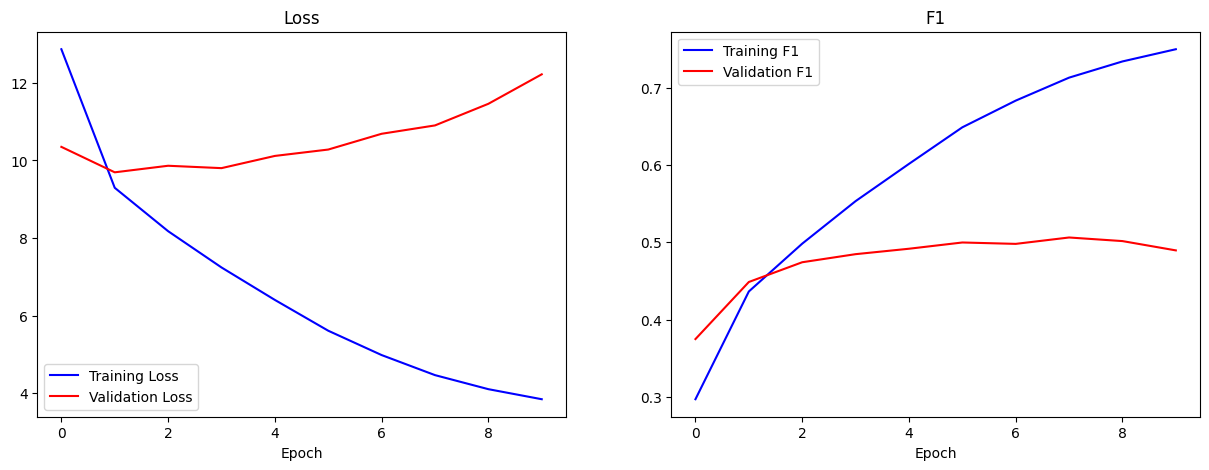

In [18]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [19]:
bilstmcrf_glove_model = bilstmcrf_glove_model.to('cpu')
torch.save(bilstmcrf_glove_model, "t1_model4_glove.pt")

Labelwise F1 Scores:
{'O': 0.49347942375445003, 'CASE_NUMBER': 0.4245049504950495, 'ORG': 0.10325047801147227, 'OTHER_PERSON': 0.24398073836276082, 'STATUTE': 0.40744368266405484, 'PROVISION': 0.428453947368421, 'COURT': 0.3403141361256545, 'WITNESS': 0.21678321678321677, 'PRECEDENT': 0.4490481522956327, 'DATE': 0.46446280991735533, 'PETITIONER': 0.25925925925925924, 'GPE': 0.24671052631578946, 'RESPONDENT': 0.22222222222222224, 'JUDGE': 0.3181818181818182}
Labelwise Accuracy Scores:
{'O': 0.9742534595775674, 'CASE_NUMBER': 0.7376344086021506, 'ORG': 0.11513859275053305, 'OTHER_PERSON': 0.3227176220806794, 'STATUTE': 0.687603305785124, 'PROVISION': 0.7496402877697842, 'COURT': 0.5158730158730159, 'WITNESS': 0.2767857142857143, 'PRECEDENT': 0.8150406504065041, 'DATE': 0.8672839506172839, 'PETITIONER': 0.35, 'GPE': 0.32751091703056767, 'RESPONDENT': 0.2857142857142857, 'JUDGE': 0.4666666666666667}


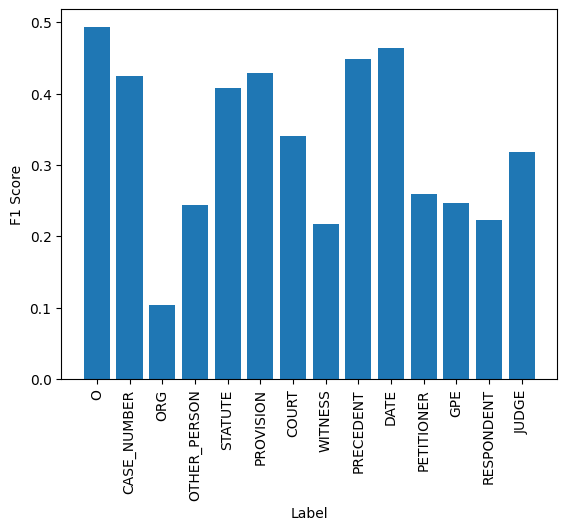

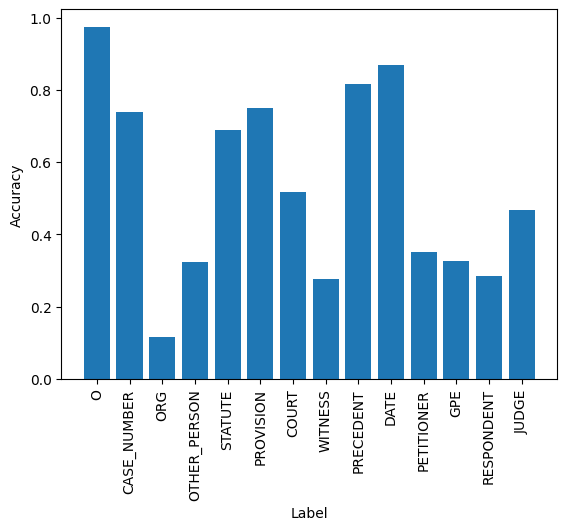

Bi-LSTM CRF with GloVe ==> Accuracy: 0.9097, F1: 0.4396


In [20]:
test_accuracy, test_f1 = test("t1_model4_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

# For FastText Embeddings

In [21]:
input_size, hidden_size, output_size = 300, 128, 27
bilstmcrf_fasttext_model = BiLSTM_CRF(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bilstmcrf_fasttext_model.parameters(), lr=0.001)

In [22]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        bilstmcrf_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 9.6664, Accuracy: 0.9191, F1: 0.4671
Validation: Loss: 6.3079, Accuracy: 0.9410, F1: 0.5864
Epoch 2/10
Training: Loss: 5.2416, Accuracy: 0.9510, F1: 0.6462
Validation: Loss: 5.5731, Accuracy: 0.9478, F1: 0.6638
Epoch 3/10
Training: Loss: 4.0555, Accuracy: 0.9613, F1: 0.7315
Validation: Loss: 5.1572, Accuracy: 0.9519, F1: 0.6922
Epoch 4/10
Training: Loss: 3.2141, Accuracy: 0.9692, F1: 0.7864
Validation: Loss: 5.1206, Accuracy: 0.9549, F1: 0.7102
Epoch 5/10
Training: Loss: 2.5100, Accuracy: 0.9758, F1: 0.8284
Validation: Loss: 5.3993, Accuracy: 0.9553, F1: 0.7138
Epoch 6/10
Training: Loss: 1.9277, Accuracy: 0.9818, F1: 0.8715
Validation: Loss: 5.5007, Accuracy: 0.9559, F1: 0.7184
Epoch 7/10
Training: Loss: 1.5175, Accuracy: 0.9859, F1: 0.9012
Validation: Loss: 6.0103, Accuracy: 0.9557, F1: 0.7181
Epoch 8/10
Training: Loss: 1.2113, Accuracy: 0.9887, F1: 0.9238
Validation: Loss: 6.0818, Accuracy: 0.9559, F1: 0.7162
Epoch 9/10
Training: Loss: 0.9616, Accuracy: 0.9

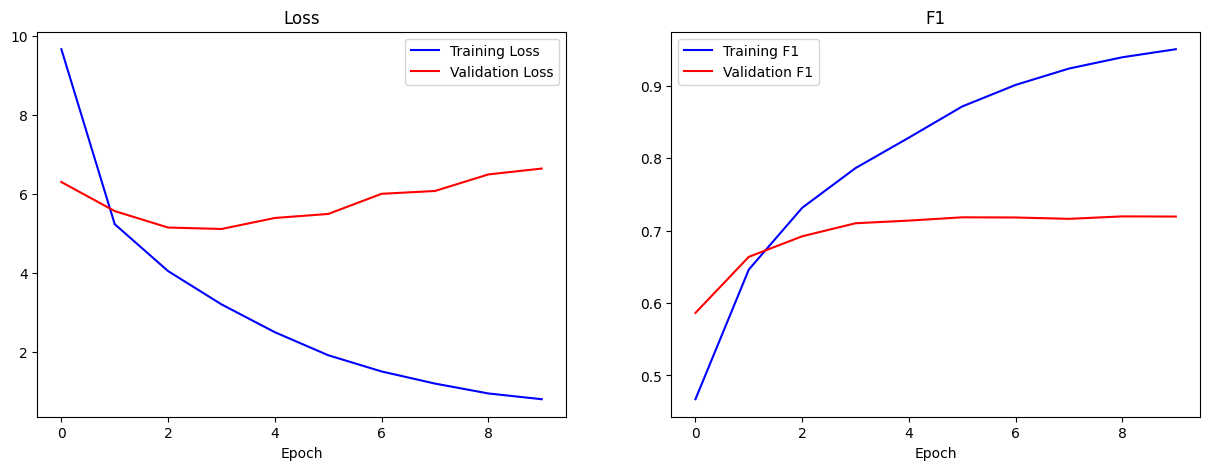

In [23]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [24]:
bilstmcrf_fasttext_model = bilstmcrf_fasttext_model.to('cpu')
torch.save(bilstmcrf_fasttext_model, "t1_model4_fasttext.pt")

Labelwise F1 Scores:
{'O': 0.49682077217671744, 'CASE_NUMBER': 0.4535840188014101, 'ORG': 0.3309557774607703, 'OTHER_PERSON': 0.42420537897310506, 'STATUTE': 0.4868532654792197, 'PROVISION': 0.47783621337340343, 'COURT': 0.45454545454545453, 'WITNESS': 0.3812154696132597, 'PRECEDENT': 0.4652173913043478, 'DATE': 0.4723127035830619, 'PETITIONER': 0.3548387096774194, 'GPE': 0.37771739130434784, 'RESPONDENT': 0.2631578947368421, 'JUDGE': 0.423076923076923}
Labelwise Accuracy Scores:
{'O': 0.9873634377276038, 'CASE_NUMBER': 0.8301075268817204, 'ORG': 0.4946695095948827, 'OTHER_PERSON': 0.7367303609341825, 'STATUTE': 0.9487603305785124, 'PROVISION': 0.9151079136690647, 'COURT': 0.8333333333333334, 'WITNESS': 0.6160714285714286, 'PRECEDENT': 0.8699186991869918, 'DATE': 0.8950617283950617, 'PETITIONER': 0.55, 'GPE': 0.6069868995633187, 'RESPONDENT': 0.35714285714285715, 'JUDGE': 0.7333333333333333}


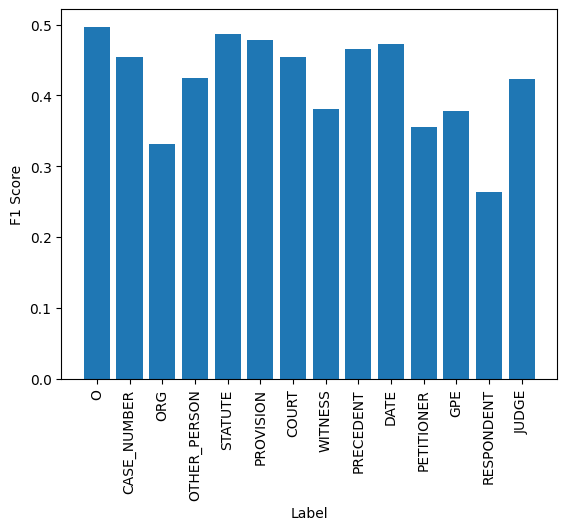

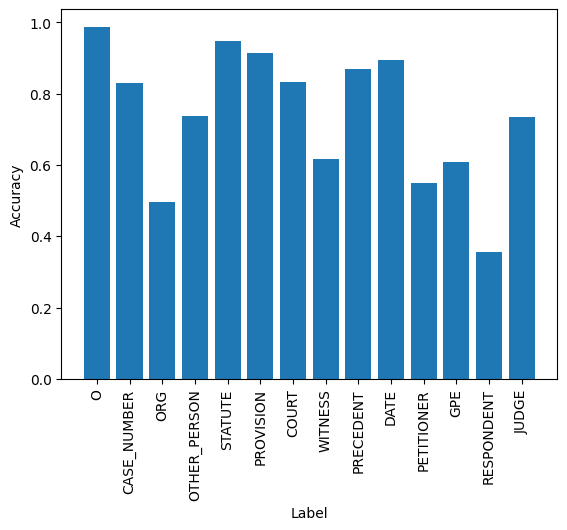

Bi-LSTM CRF with FastText ==> Accuracy: 0.9546, F1: 0.7063


In [25]:
test_accuracy, test_f1 = test("t1_model4_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=True)
print(("Bi-LSTM CRF with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))